In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor, train
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
df = pd.read_csv("generated_data.csv")
df.head()

,Product_Name,HSN_Code,Qty,Rate,Amount,Bill_No,Bill_Date,Buyer_Name
0,BROMEL FIX TYPE–2,382450,288,617,177696,5394,18-10-2023,Alvarez-Brown
1,EPOXY REGULAR(1 KG),382450,303,995,301485,6026,24-06-2022,Williams-House
2,BROMEL FIX TYPE–1,382450,909,883,802647,4626,15-07-2022,Alvarez-Brown
3,BROMEL FIX TYPE–2,382450,445,513,228285,8345,05-09-2023,Shah and Sons
4,SPARKAL GOLDEN,382450,434,80,34720,3298,02-07-2023,Alvarez-Brown


In [3]:
df.isnull().sum()

Product_Name    0
HSN_Code        0
Qty             0
Rate            0
Amount          0
Bill_No         0
Bill_Date       0
Buyer_Name      0
dtype: int64

In [4]:
df = df.drop(columns=['HSN_Code', 'Rate', 'Amount', 'Bill_No'], axis=1)
df.head()

,Product_Name,Qty,Bill_Date,Buyer_Name
0,BROMEL FIX TYPE–2,288,18-10-2023,Alvarez-Brown
1,EPOXY REGULAR(1 KG),303,24-06-2022,Williams-House
2,BROMEL FIX TYPE–1,909,15-07-2022,Alvarez-Brown
3,BROMEL FIX TYPE–2,445,05-09-2023,Shah and Sons
4,SPARKAL GOLDEN,434,02-07-2023,Alvarez-Brown


Labeling the column Product_Name and Buyer_Name for input of the model

In [5]:
label_encoder = LabelEncoder()
df['Product_Name'] = label_encoder.fit_transform(df['Product_Name'])
df['Buyer_Name'] = label_encoder.fit_transform(df['Buyer_Name'])

In [6]:
df['Bill_Date'] = pd.to_datetime(df['Bill_Date'], dayfirst=True)
df['Bill_Date'] = df['Bill_Date'].dt.to_period("M")
monthly_sales = df.groupby('Bill_Date').sum().reset_index()
monthly_sales['Bill_Date'] = monthly_sales['Bill_Date'].dt.to_timestamp()

In [7]:
monthly_sales.head()

,Bill_Date,Product_Name,Qty,Buyer_Name
0,2022-04-01,132,18479,1825
1,2022-05-01,197,14176,1748
2,2022-06-01,231,23534,1998
3,2022-07-01,180,16284,1642
4,2022-08-01,218,18540,2160


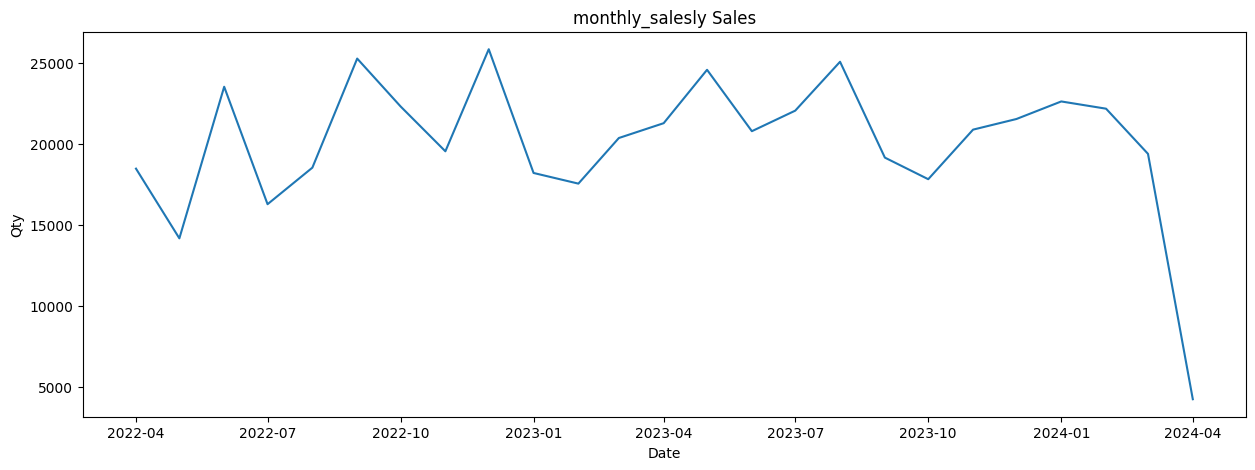

In [8]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['Bill_Date'], monthly_sales['Qty'])
plt.xlabel("Date")
plt.ylabel("Qty")
plt.title("monthly_salesly Sales")
plt.show()

In [9]:
monthly_sales['sales_diff'] = monthly_sales['Qty'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head()

,Bill_Date,Product_Name,Qty,Buyer_Name,sales_diff
1,2022-05-01,197,14176,1748,-4303.0
2,2022-06-01,231,23534,1998,9358.0
3,2022-07-01,180,16284,1642,-7250.0
4,2022-08-01,218,18540,2160,2256.0
5,2022-09-01,271,25274,2286,6734.0


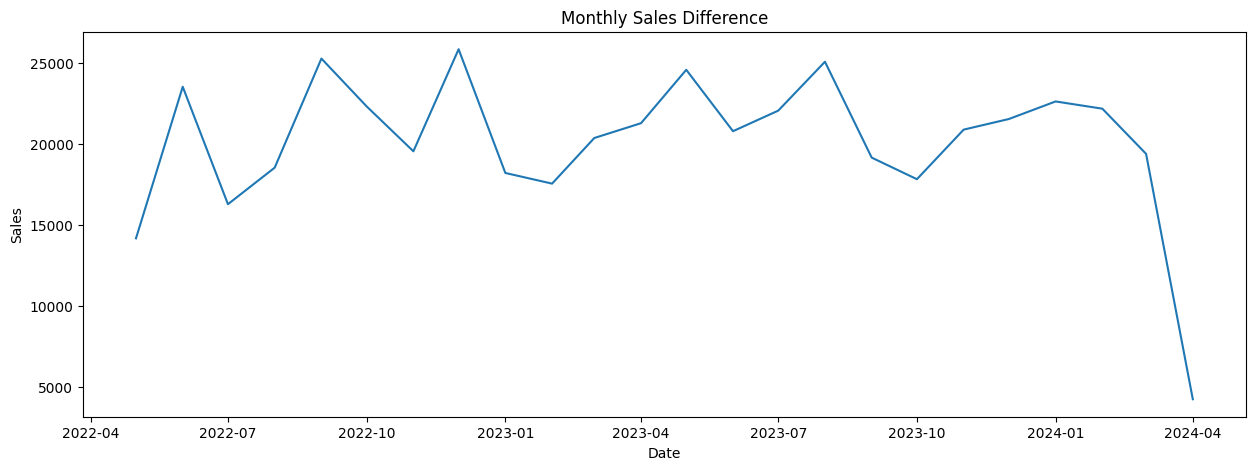

In [10]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['Bill_Date'], monthly_sales['Qty'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Sales Difference")
plt.show()

In [11]:
supervised_data = monthly_sales.drop(columns=['Bill_Date', 'Qty'], axis=1)

In [12]:
for i in range(1,13):
    col = 'month_' + str(i)
    supervised_data[col] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head()

,Product_Name,Buyer_Name,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,255,2402,3296.0,915.0,2816.0,-658.0,-7639.0,6301.0,-2771.0,-2953.0,6734.0,2256.0,-7250.0,9358.0,-4303.0
1,181,2246,-3790.0,3296.0,915.0,2816.0,-658.0,-7639.0,6301.0,-2771.0,-2953.0,6734.0,2256.0,-7250.0,9358.0
2,223,2071,1268.0,-3790.0,3296.0,915.0,2816.0,-658.0,-7639.0,6301.0,-2771.0,-2953.0,6734.0,2256.0,-7250.0
3,242,2545,3018.0,1268.0,-3790.0,3296.0,915.0,2816.0,-658.0,-7639.0,6301.0,-2771.0,-2953.0,6734.0,2256.0
4,200,1675,-5917.0,3018.0,1268.0,-3790.0,3296.0,915.0,2816.0,-658.0,-7639.0,6301.0,-2771.0,-2953.0,6734.0


In [13]:
train_data = supervised_data[:12]
test_data = supervised_data[-12:]
print("train_data shape: ", train_data.shape)
print("test_data shape: ", test_data.shape)

train_data shape:  (12, 15)
test_data shape:  (12, 15)


In [14]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [15]:
x_train, y_train = train_data[:,1:], train_data[:,0:1]
x_test, y_test = test_data[:,1:], test_data[:,0:1]
y_test = y_test.ravel()
print("X_train shape: ", x_train.shape)
print("Y_train shape: ", y_train.shape)
print("X_test shape: ", x_test.shape)
print("Y_test shape: ", y_test.shape)

X_train shape:  (12, 14)
Y_train shape:  (12, 1)
X_test shape:  (12, 14)
Y_test shape:  (12,)


In [16]:
sales_date = monthly_sales['Bill_Date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_date)

In [17]:
act_sales = monthly_sales['Qty'][-13:].to_list()
act_sales

[21285,
 24581,
 20791,
 22059,
 25077,
 19160,
 17827,
 20887,
 21543,
 22627,
 22180,
 19392,
 4245]

In [18]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
linear_pred = linear_model.predict(x_test)

In [19]:
linear_pred = linear_pred.reshape(-1,1)
# it contains input features an the test data abd predicted output
linear_pred_test_set = np.concatenate([linear_pred, x_test], axis=1)
linear_pred_test_set = scaler.inverse_transform(linear_pred_test_set)

In [20]:
result_list = []
for index in range(0, len(linear_pred_test_set)):
    result_list.append(linear_pred_test_set[index][0] + act_sales[index])
linear_pred_series = pd.Series(result_list, name='Linear Prediction')
predict_df = predict_df.merge(linear_pred_series, left_index = True, right_index = True)

In [21]:
mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['Qty'][-12:]))
mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['Qty'][-12:])
R2 = r2_score(predict_df['Linear Prediction'], monthly_sales['Qty'][-12:])
print("mean square error: ", mse)
print("mean absolute error: ", mae)
print("R square error: ", R2)

mean square error:  5189.229727682777
mean absolute error:  3453.5
R square error:  -5.594883726713552


C:\Users\INTEL\AppData\Local\Temp\ipykernel_12720\3986265795.py:7: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend('Actual Qty', 'Predicted Qty')


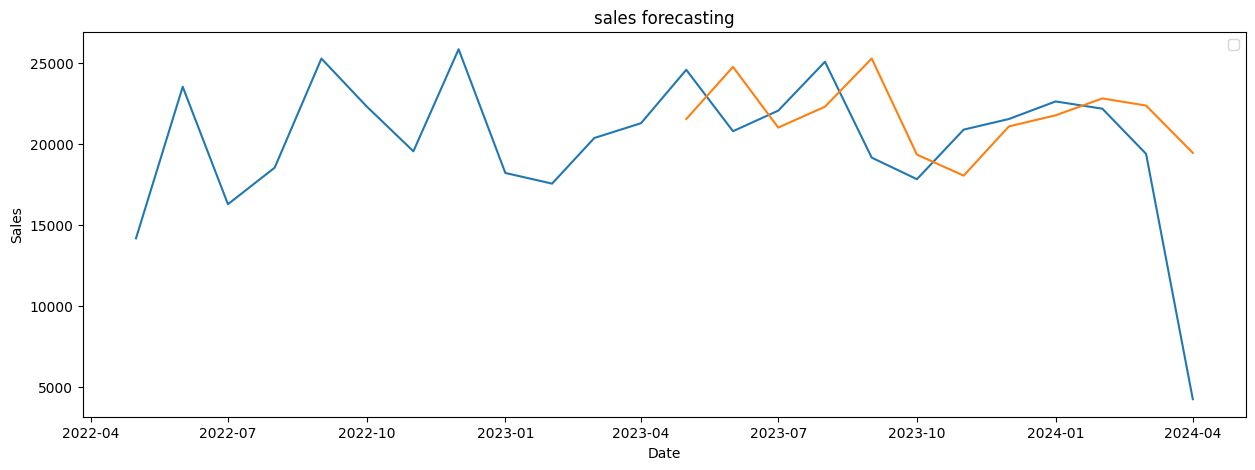

In [22]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['Bill_Date'], monthly_sales['Qty'])
plt.plot(predict_df['Bill_Date'], predict_df['Linear Prediction'])
plt.title("sales forecasting")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend('Actual Qty', 'Predicted Qty')
plt.show()